# Importing PySpark and Reading the Dataset

## Importing PySpark

In [1]:
import os

# os.environ['HADOOP_HOME'] = 'D:\Programming\hadoop-3.4.1'

from pyspark.sql import SparkSession, DataFrame

spark = SparkSession.builder.appName('Task02').getOrCreate()

print(spark)

In [2]:
spark.version

'3.5.5'

## Reading the Dataset

In [3]:
import_file_path = 'gold_prices.csv'

df = spark.read.csv(import_file_path, header=True, inferSchema=True)
df.show(5)

+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows



In [4]:
df.describe().show()

+-------+------------------+------------------+
|summary|         Buy Price|        Sell Price|
+-------+------------------+------------------+
|  count|              5565|              5565|
|   mean|  45.5656999101527|46.017667565139305|
| stddev|14.892834946578136|15.353833530564659|
|    min|             21.13|             21.19|
|    max|              89.0|              91.3|
+-------+------------------+------------------+



In [5]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Buy Price: double (nullable = true)
 |-- Sell Price: double (nullable = true)



# Generating Samples

## Main Function

In [6]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
import random


def generate_samples(dataset: DataFrame, random_state: int = None,
                     n_days: int = 10, n_sample: int = 4000,
                     target_buy_col: str = 'Buy Price',
                     target_sell_col: str = 'Sell Price') -> DataFrame:
	"""
  A function to generate a sample dataframe from a dataset.

  :param dataset: Dataframe for sampling.
  :param random_state: Seed to set for consistent reproduction.
  :param n_days: Range of days prior to t, default is 10.
  :param n_sample: Number of samples to generate, default is 1000.
  :param target_buy_col: Target buy column to collect.
  :param target_sell_col: Target sell column to collect.
  :return: Sample dataframe with n features.
  """

	"""
	Step 1: Setting up the dataframe
	"""
	samples = dataset
	window = Window.orderBy('Date')
	index_col = 'Index'
	samples = samples.withColumn(index_col, F.row_number().over(window))

	"""
  Step 2: Generating a list of random indices
  """
	if random_state is not None:
		random.seed(random_state)

	# Making sure it starts from a valid date to collect n_days previous rows
	size = samples.agg(F.max(index_col)).collect()[0][0]
	population = range(n_days + 1, size + 1)
	sample_indices = set(random.sample(population, n_sample))

	"""
  Step 3: Collecting the buy price of previous n_days:
  - Generating a temporary column for indexing
  - Generate values for rows whose index is within sample_indices
  """
	buy_features = []
	sell_features = []
	condition = F.col(index_col).isin(sample_indices)

	for i in range(1, n_days + 1):
		buy_feature_col = f'b{i}'
		sell_feature_col = f's{i}'
		buy_features.append(buy_feature_col)
		sell_features.append(sell_feature_col)

		samples = samples.select(
			F.col('*'),

			F.when(
				condition,
				F.lag(target_buy_col, i, None).over(window)
			).otherwise(
				F.lit(None)
			).alias(buy_feature_col),

			F.when(
				condition,
				F.lag(target_sell_col, i, None).over(window)
			).otherwise(
				F.lit(None)
			).alias(sell_feature_col),
		)

	"""
  Step 4: Cleaning the dataset:
  - Dropping unnecessary columns as well as null.
  - Changing target_col column name to 'Current {target_col}'
  """
	samples = samples.drop(index_col)
	samples = samples.withColumnRenamed(target_buy_col, f'Current {target_buy_col}') \
		.withColumnRenamed(target_sell_col, f'Current {target_sell_col}')

	samples = samples.dropna()

	"""
  Transforming the sample dataframe by collecting feature
   columns into a single column named 'Previous {target_col}(s)'
  """
	for features, col in [[buy_features, target_buy_col], [sell_features, target_sell_col]]:
		assembler = VectorAssembler(
			inputCols=features,
			outputCol=f'Previous {col}(s)',
		)

		samples = assembler.transform(samples)

	"""
  Dropping all the previous feature columns
  """
	for col in buy_features + sell_features:
		samples = samples.drop(col)

	return samples

In [7]:
sample_df = generate_samples(df, random_state=38)
# isCorrect = True
#
# while isCorrect:
# 	sample_df = generate_samples(
# 		df.limit(5),
# 		n_days=2,
# 		n_sample=3,
# 		random_state=42,
# 		cols_to_remove=['Date', 'Sell Price']
# 	)
#
# 	if sample_df.count() == 3:
# 		isCorrect = False

sample_df.show(10)

+----------+-----------------+------------------+---------------------+----------------------+
|      Date|Current Buy Price|Current Sell Price|Previous Buy Price(s)|Previous Sell Price(s)|
+----------+-----------------+------------------+---------------------+----------------------+
|2009-08-12|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-13|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-15|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-16|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-17|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-18|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-20|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-22|            21.13|             21.19| 

## Saving the Generated Samples

In [8]:
# from pyspark.sql.types import StringType
#
# export_df = sample_df
#
# # Converting the Dataframe to a suitable format to export
# for col in ['Buy', 'Sell']:
# 	col = f'Previous {col} Price(s)'
# 	export_df = export_df.withColumn(
# 		col,
# 		F.col(col).cast(StringType())
# 	)
#
# export_file_path = 'generated_samples'
#
# export_df.coalesce(1).write.csv(
# 	export_file_path,
# 	header=True,
# 	mode='overwrite'
# )
#
# print(f'Generated samples saved to {export_file_path}')

# Training and Predicting

## Splitting the Training and Testing Sets

In [9]:
train_set, test_set = sample_df.randomSplit(weights=[0.7, 0.3], seed=2)

In [10]:
train_set.show(10)

+----------+-----------------+------------------+---------------------+----------------------+
|      Date|Current Buy Price|Current Sell Price|Previous Buy Price(s)|Previous Sell Price(s)|
+----------+-----------------+------------------+---------------------+----------------------+
|2009-08-12|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-13|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-15|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-16|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-18|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-20|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-22|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-25|            21.13|             21.19| 

In [11]:
test_set.show(10)

+----------+-----------------+------------------+---------------------+----------------------+
|      Date|Current Buy Price|Current Sell Price|Previous Buy Price(s)|Previous Sell Price(s)|
+----------+-----------------+------------------+---------------------+----------------------+
|2009-08-17|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-08-24|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...|
|2009-09-24|            22.23|             22.28| [22.27,22.22,22.0...|  [22.32,22.28,22.1...|
|2009-09-26|            22.04|             22.09| [22.07,22.23,22.2...|  [22.13,22.28,22.3...|
|2009-10-02|            22.18|             22.23| [22.25,22.19,22.0...|  [22.3,22.24,22.14...|
|2009-10-12|            23.15|              23.2| [23.07,23.07,23.0...|  [23.12,23.12,23.0...|
|2009-10-16|            23.47|             23.52| [23.57,23.76,23.4...|  [23.64,23.84,23.5...|
|2009-10-21|            23.74|             23.79| 

## Training the Models

In [12]:
from pyspark.ml.regression import LinearRegression


def create_model(target_col: str, dataset: DataFrame):
	lg = LinearRegression(
		featuresCol=f'Previous {target_col} Price(s)',
		labelCol=f'Current {target_col} Price',
		predictionCol=f'Predicted {target_col} Price',
		solver='l-bfgs',
	)

	return lg.fit(dataset)


lg_buy_model = create_model('Buy', train_set)
lg_sell_model = create_model('Sell', train_set)

## Making Predictions

In [13]:
predictions = lg_buy_model.transform(test_set)
predictions = lg_sell_model.transform(predictions)
predictions.show(5)

+----------+-----------------+------------------+---------------------+----------------------+-------------------+--------------------+
|      Date|Current Buy Price|Current Sell Price|Previous Buy Price(s)|Previous Sell Price(s)|Predicted Buy Price|Predicted Sell Price|
+----------+-----------------+------------------+---------------------+----------------------+-------------------+--------------------+
|2009-08-17|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...| 21.138918864883895|   21.20003902038235|
|2009-08-24|            21.13|             21.19| [21.13,21.13,21.1...|  [21.19,21.19,21.1...| 21.138918864883895|   21.20003902038235|
|2009-09-24|            22.23|             22.28| [22.27,22.22,22.0...|  [22.32,22.28,22.1...|   22.3010512673204|  22.320129794228016|
|2009-09-26|            22.04|             22.09| [22.07,22.23,22.2...|  [22.13,22.28,22.3...|  22.06832779774004|  22.150291609219487|
|2009-10-02|            22.18|             22.23

# Evaluating the Model

In [14]:
def evaluate_model(dataset: DataFrame, model: LinearRegression):
	"""
  A function to evaluate the model performance based on a given dataset.
  :param dataset: The dataframe for evaluation.
  :param model: A Linear Regression model.
  :return: Dictionary of evaluation results using different metrics.
  """

	evaluation = model.evaluate(dataset)

	metrics = {
		'Root Mean Squared Error': evaluation.rootMeanSquaredError,
		'R2': evaluation.r2,
		'Mean Absolute Error': evaluation.meanAbsoluteError,
		'Explained Variance': evaluation.explainedVariance,
	}

	max_len = 24

	print('\n', model)
	for metric in metrics.keys():
		print(f'{metric:<{max_len}}: {metrics.get(metric):.4f}')

	return metrics

## On the Training Set

In [15]:
buy_train_evaluation = evaluate_model(train_set, lg_buy_model)
sell_train_evaluation = evaluate_model(train_set, lg_sell_model)


 LinearRegressionModel: uid=LinearRegression_53b9f1130fbf, numFeatures=10
Root Mean Squared Error : 0.3232
R2                      : 0.9995
Mean Absolute Error     : 0.1450
Explained Variance      : 225.7249

 LinearRegressionModel: uid=LinearRegression_2738380add4a, numFeatures=10
Root Mean Squared Error : 0.3062
R2                      : 0.9996
Mean Absolute Error     : 0.1406
Explained Variance      : 240.1171


## On the Testing Set

In [16]:
buy_test_evaluation = evaluate_model(test_set, lg_buy_model)
sell_test_evaluation = evaluate_model(test_set, lg_sell_model)


 LinearRegressionModel: uid=LinearRegression_53b9f1130fbf, numFeatures=10
Root Mean Squared Error : 0.2975
R2                      : 0.9996
Mean Absolute Error     : 0.1356
Explained Variance      : 226.5322

 LinearRegressionModel: uid=LinearRegression_2738380add4a, numFeatures=10
Root Mean Squared Error : 0.2913
R2                      : 0.9996
Mean Absolute Error     : 0.1319
Explained Variance      : 240.6501


# Illustration Charts

## Loss History

In [17]:
import matplotlib.pyplot as plt


def plot_loss_history(buy_model: LinearRegression, sell_model: LinearRegression):
	buy_loss_history = buy_model.summary.objectiveHistory
	sell_loss_history = sell_model.summary.objectiveHistory

	if buy_loss_history and sell_loss_history:
		plt.figure(figsize=(8, 5))
		plt.plot(buy_loss_history, label='Buy Loss')
		plt.plot(sell_loss_history, label='Sell Loss')
		plt.title('Training Objective Function History')
		plt.xlabel('Iteration')
		plt.ylabel('Objective Function Value (Loss + Regularization)')
		plt.grid(True)
		plt.legend()
		plt.show()

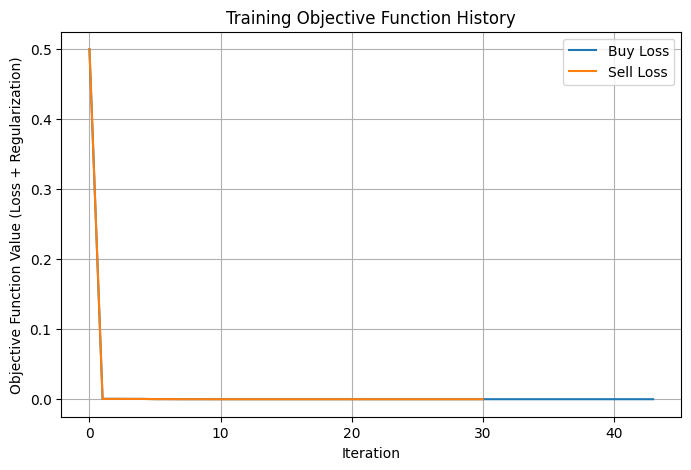

In [18]:
plot_loss_history(lg_buy_model, lg_sell_model)

## Performance Comparison

In [19]:
import numpy as np


def plot_metrics_two_models(
		train_eval_model1: dict,
		test_eval_model1: dict,
		train_eval_model2: dict,
		test_eval_model2: dict,
		first_set: str = 'Dataset 1',
		second_set: str = 'Dataset 2',
		model1_name: str = 'Model 1',
		model2_name: str = 'Model 2'
):
	"""
  Plots evaluation metrics for two models, comparing their training and test set performance.

	:param train_eval_model1: Dictionary of training metrics for model 1.
	:param test_eval_model1: Dictionary of test metrics for model 1.
	:param train_eval_model2:Dictionary of training metrics for model 2.
	:param test_eval_model2: Dictionary of test metrics for model 2.
	:param first_set: Name of the first dataset.
	:param second_set: Name of the second dataset.
	:param model1_name: Name of the first model.
	:param model2_name: Name of the second model.
	"""

	# --- Plot for general metrics (excluding Explained Variance) ---
	train_eval_m1_copy = train_eval_model1.copy()
	test_eval_m1_copy = test_eval_model1.copy()
	train_eval_m2_copy = train_eval_model2.copy()
	test_eval_m2_copy = test_eval_model2.copy()

	# Pop 'Explained Variance' if it exists, store it for later
	train_var_m1 = train_eval_m1_copy.pop('Explained Variance', None)
	test_var_m1 = test_eval_m1_copy.pop('Explained Variance', None)
	train_var_m2 = train_eval_m2_copy.pop('Explained Variance', None)
	test_var_m2 = test_eval_m2_copy.pop('Explained Variance', None)

	evaluation_metrics = list(train_eval_m1_copy.keys())
	if evaluation_metrics:
		x = np.arange(len(evaluation_metrics))
		n_bars_per_group = 4
		total_width_for_group = 0.8  # Total width for the 4 bars for one metric
		bar_width = total_width_for_group / n_bars_per_group  # Width of a single bar

		fig, ax = plt.subplots(figsize=(12, 7))

		rects1 = ax.bar(x - 1.5 * bar_width,
		                [train_eval_m1_copy.get(m, 0) for m in evaluation_metrics],  # Use .get for safety
		                bar_width,
		                label=f'{model1_name} - {first_set}')
		rects2 = ax.bar(x - 0.5 * bar_width,
		                [test_eval_m1_copy.get(m, 0) for m in evaluation_metrics],
		                bar_width,
		                label=f'{model1_name} - {second_set}')
		rects3 = ax.bar(x + 0.5 * bar_width,
		                [train_eval_m2_copy.get(m, 0) for m in evaluation_metrics],
		                bar_width,
		                label=f'{model2_name} - {first_set}')
		rects4 = ax.bar(x + 1.5 * bar_width,
		                [test_eval_m2_copy.get(m, 0) for m in evaluation_metrics],
		                bar_width,
		                label=f'{model2_name} - {second_set}')

		ax.set_ylabel('Metric Value')
		ax.set_title('Model Evaluation Comparison')
		ax.set_xticks(x)
		ax.set_xticklabels(evaluation_metrics)
		ax.legend()

		ax.bar_label(rects1, fmt='%.4f')
		ax.bar_label(rects2, fmt='%.4f')
		ax.bar_label(rects3, fmt='%.4f')
		ax.bar_label(rects4, fmt='%.4f')

		fig.tight_layout()
		plt.show()

	# --- Plot for 'Explained Variance' specifically ---
	# Check if any of the variance values are not None
	if any(v is not None for v in [train_var_m1, test_var_m1, train_var_m2, test_var_m2]):
		metric_name = 'Explained Variance'

		# Prepare data for a grouped bar chart
		labels = [f'{first_set} Set', f'{second_set} Set']
		m1_variances = [train_var_m1 if train_var_m1 is not None else 0,
		                test_var_m1 if test_var_m1 is not None else 0]
		m2_variances = [train_var_m2 if train_var_m2 is not None else 0,
		                test_var_m2 if test_var_m2 is not None else 0]

		x_ev = np.arange(len(labels))  # the label locations [0, 1]
		width_ev = 0.35  # the width of the bars

		fig_ev, ax_ev = plt.subplots(figsize=(10, 6))

		# Bars for Model 1
		rects_ev1 = ax_ev.bar(x_ev - width_ev / 2, m1_variances, width_ev,
		                      label=model1_name, color='deepskyblue')
		# Bars for Model 2
		rects_ev2 = ax_ev.bar(x_ev + width_ev / 2, m2_variances, width_ev,
		                      label=model2_name, color='lightcoral')

		# Add some text for labels, title and custom x-axis tick labels, etc.
		ax_ev.set_ylabel(f'{metric_name} Value')
		ax_ev.set_title(f'{metric_name} Comparison: {first_set} vs. {second_set}')
		ax_ev.set_xticks(x_ev)
		ax_ev.set_xticklabels(labels)
		ax_ev.legend()

		ax_ev.bar_label(rects_ev1, padding=3, fmt='%.4f')
		ax_ev.bar_label(rects_ev2, padding=3, fmt='%.4f')

		# Set y-axis limits to be more appropriate for variance (e.g., 0 to 1.1 if it's a score)
		# This is optional and depends on the expected range of explained variance
		# For scores typically between 0 and 1:
		all_variances = [v for v in m1_variances + m2_variances if v is not None]
		if all_variances and max(all_variances) <= 1.1 and min(all_variances) >= -0.1:  # A bit of margin
			ax_ev.set_ylim([min(0, min(all_variances) - 0.1), max(1.05, max(all_variances) + 0.1)])

		fig_ev.tight_layout()
		plt.show()

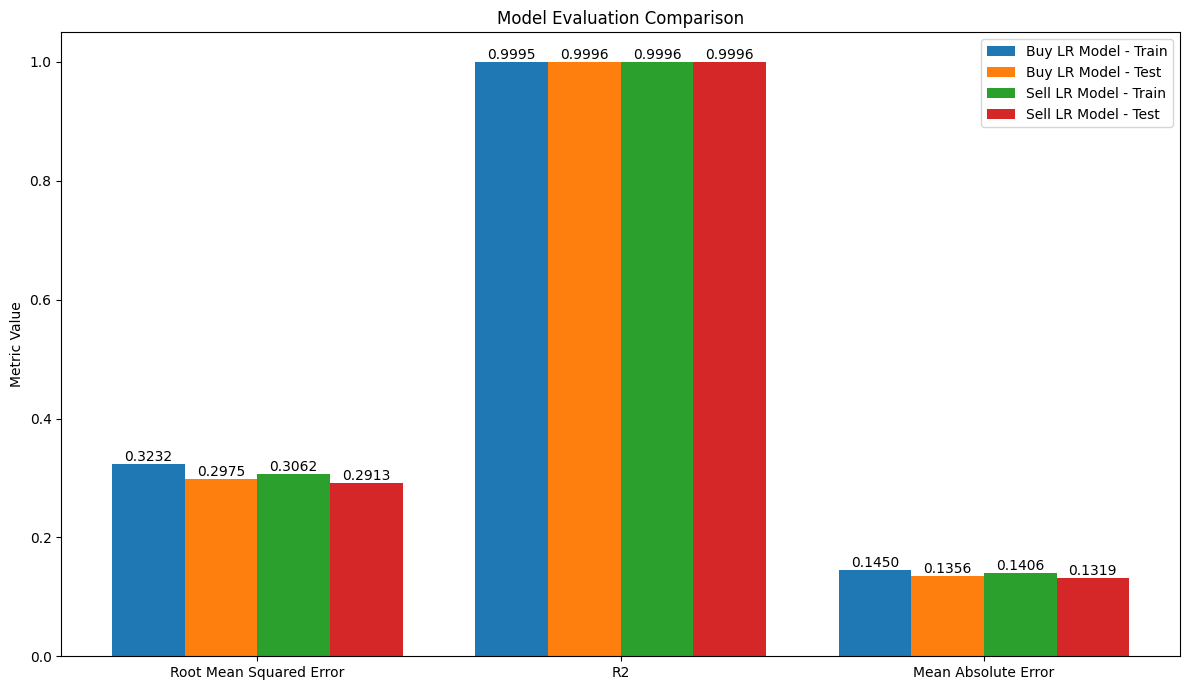

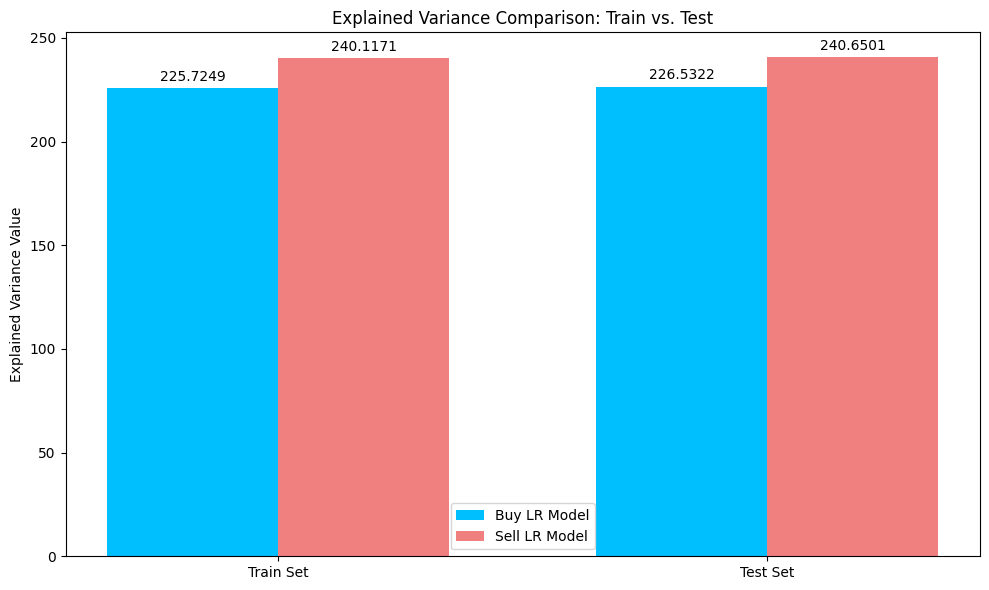

In [20]:
plot_metrics_two_models(
	buy_train_evaluation, buy_test_evaluation,
	sell_train_evaluation, sell_test_evaluation,
	'Train', 'Test',
	'Buy LR Model', 'Sell LR Model'
)

In [20]:
spark.stop()